In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [20]:
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
            return self.transform_mapping[int(y)]            

In [21]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [22]:
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        k = np.where(Y_test[i] == 1)
        if(y == k):
            acc += 1.0
    return acc / Y_test.shape[0]

In [23]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_no_labels = pickle.load(fin)

X = train_data['data']
Y = train_data['target']
X_test_norm = test_no_labels['data']

In [24]:
X = X.astype('float')
mean = np.mean(X, axis = 0)
std = np.std(X, axis=0) + 0.001
X = (X - mean) / std
X_test_norm = (X_test_norm - mean) / std


In [25]:
from sklearn.cross_validation import train_test_split

t = OneHotEncoder()
Y_n = np.array([t.transform(i) for i in Y])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_n, test_size=0.33, random_state = 10)

In [26]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
    
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx


class Max:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz
    
    
class Softmax:
    def forward(self, x):
        self.x = x - np.max(x)
        exps = np.exp(self.x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

    
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p) #???
        return x * self.mask
    
    def backward(self, dz, lr=0.001):
        return dz * self.mask
    
    
class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat) )
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

In [27]:
class MnistNet:
    def __init__(self, rlambda=0.0):
        self.drop1 = Dropout()
        self.d1 = Dense(784, 256, rlambda)
        self.m1 = Max()
        self.d2 = Dense(256, 256, rlambda)
        self.m2 = Max()
        self.d3 = Dense(256, 128, rlambda)
        self.drop2 = Dropout(0.25)
        self.m3 = Max()
        self.d4 = Dense(128, 32, rlambda)
        self.m4 = Max()
        self.d5 = Dense(32, 10, rlambda)
        self.m5 = Max()
        self.s = Softmax()
    
    def forward(self, x):
        x = self.drop1.forward(x)
        x = self.d1.forward(x)
        x = self.m1.forward(x)
        x = self.d2.forward(x)
        x = self.m2.forward(x)
        x = self.d3.forward(x)
        x = self.drop2.forward(x)
        x = self.m3.forward(x)
        x = self.d4.forward(x)
        x = self.m4.forward(x)
        x = self.d5.forward(x)
        x = self.m5.forward(x)
        net = self.s.forward(x)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m5.backward(dz, lr)
        dz = self.d5.backward(dz, lr)
        dz = self.m4.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.m3.backward(dz, lr)
        dz = self.drop2.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        dz = self.drop1.backward(dz, lr)
        return dz

In [28]:
import tqdm

net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.001

loss_train, loss_test, acc_train, acc_test = [], [], [], []
for iter in tqdm.tqdm_notebook(range(20)):
    l_train = 0.
    sh = list(range(X_train.shape[0]))
    np.random.shuffle(sh)
    net.drop1.train = True
    net.drop2.train = True
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        l_train += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    l_train /= Y_train.shape[0]
    loss_train.append(l_train)
    
    l_test = 0.
    net.drop1.train = False
    net.drop2.train = False
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        l_test += L
    l_test /= Y_test.shape[0]
    loss_test.append(l_test)
    
    a_train = compute_acc(X_train, Y_train, net)    
    a_test = compute_acc(X_test, Y_test, net)
    acc_test.append(a_test)
    acc_train.append(a_train)
    #make_submission(X_test_norm, net, fname='submission_n{}.csv'.format(iter))
    fmt = iter, l_train, a_train, l_test, a_test
    print("№{}. Train loss|accuracy : {:.5}|{:.4%}. Test loss|accuracy: {:.5}|{:.4%}".format(*fmt))
    

№0. Train loss|accuracy : 0.90127|92.2729%. Test loss|accuracy: 0.46845|91.4921%
№1. Train loss|accuracy : 0.56239|94.6610%. Test loss|accuracy: 0.41039|93.6681%
№2. Train loss|accuracy : 0.49534|95.4684%. Test loss|accuracy: 0.3814|94.5512%
№3. Train loss|accuracy : 0.4577|96.4463%. Test loss|accuracy: 0.36258|95.5613%
№4. Train loss|accuracy : 0.43105|96.7903%. Test loss|accuracy: 0.35008|95.7633%
№5. Train loss|accuracy : 0.41465|96.7136%. Test loss|accuracy: 0.35071|95.5960%
№6. Train loss|accuracy : 0.39796|97.6347%. Test loss|accuracy: 0.33205|96.6176%
№7. Train loss|accuracy : 0.39039|97.5864%. Test loss|accuracy: 0.3361|96.4387%
№8. Train loss|accuracy : 0.37357|97.9758%. Test loss|accuracy: 0.32743|96.8831%
№9. Train loss|accuracy : 0.37168|97.6546%. Test loss|accuracy: 0.33099|96.4848%
№10. Train loss|accuracy : 0.36512|98.3397%. Test loss|accuracy: 0.32273|97.1198%
№11. Train loss|accuracy : 0.35548|98.4364%. Test loss|accuracy: 0.31619|97.2872%
№12. Train loss|accuracy : 0.

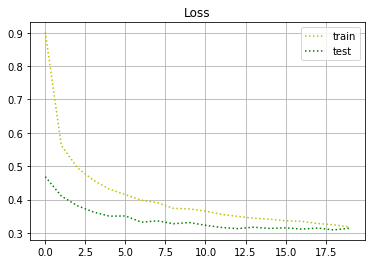

In [29]:
plt.grid(True)
plt.title('Loss')
plt.plot(loss_train, 'y:', label = 'train')
plt.plot(loss_test, 'g:', label = 'test')
plt.legend()

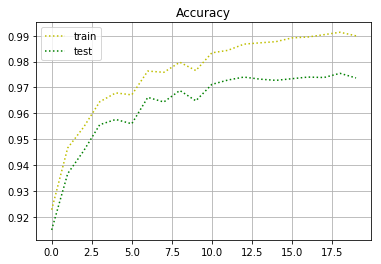

In [30]:
plt.grid(True)
plt.title('Accuracy')
plt.plot(acc_train, 'y:', label = 'train')
plt.plot(acc_test, 'g:', label = 'test')
plt.legend()

In [ ]:
make_submission(X_test_norm, net, fname = "final_submission.csv")